In [1]:
#Root 경로로 이동
%cd ..

#참고사이트 : https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606

d:\MyGit\BrainMR_MCI


In [9]:
import dataloader
import pandas as pd
import utils
import numpy as np
from scipy import ndimage

In [5]:
config = utils.load_config()

In [6]:
df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])
df_dataset = df_dataset.dropna()
img_dataset = dataloader.load_dataset(df_dataset[:10],preprocess=False)

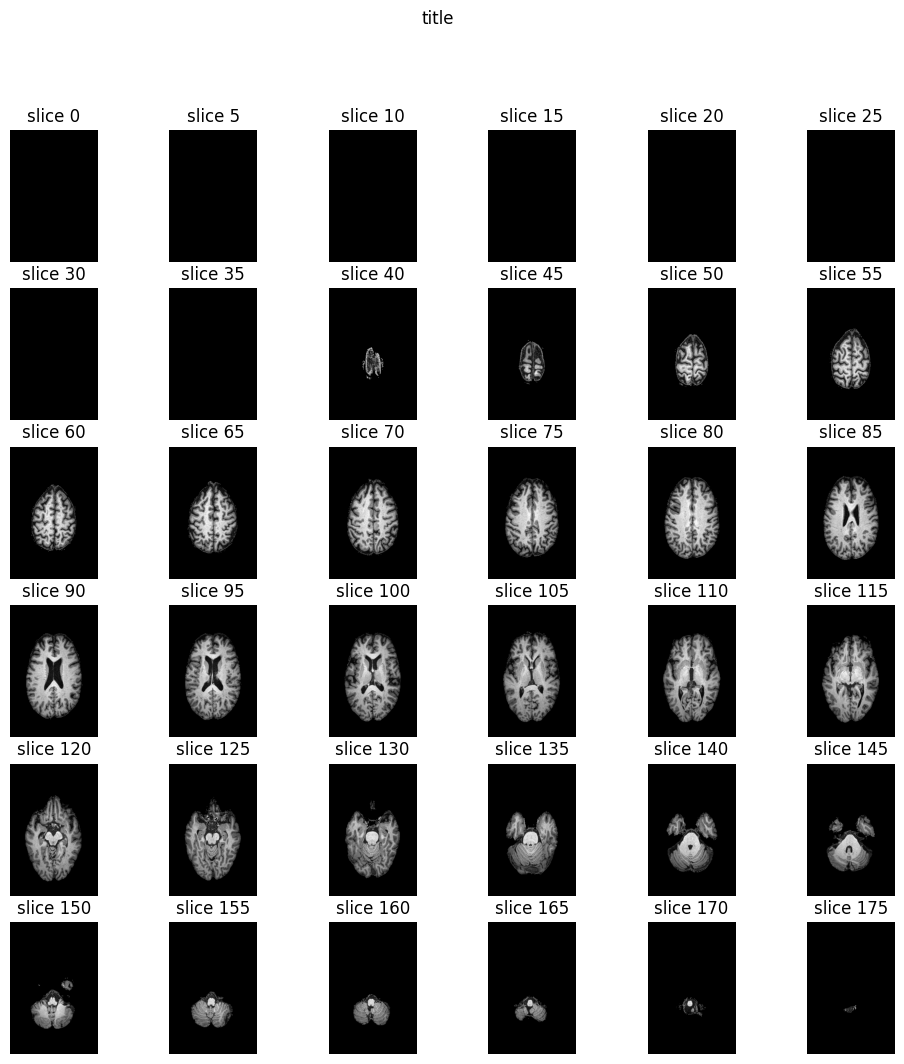

In [28]:
utils.stack_plot(img_dataset[0])

In [6]:
img_dataset[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

1799.0206


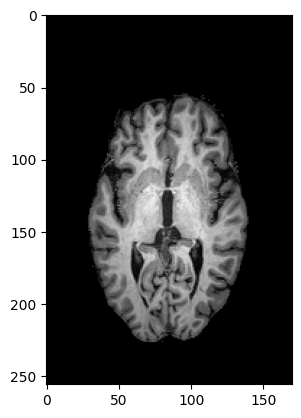

In [7]:
#image crop
sample_image = img_dataset[0][:,:,110]
utils.image_plot(sample_image)
print(sample_image.max())

1.0


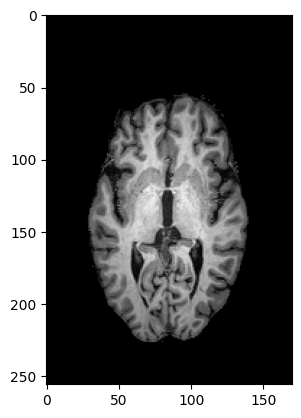

In [29]:
image = sample_image / sample_image.max()
utils.image_plot(image)
print(image.max())

In [18]:
sample_image[:,120]

array([   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.

In [13]:
def crop_images(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0
    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1],top_left[2]:bottom_right[2]]
    
    return croped_image

def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0
    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]
    
    return croped_image


def add_pad(image, pad_top = 10,pad_left = 10,pad_depth=10):
    
    height, width, depth = image.shape
    new_height = height + pad_top*2
    new_width = width + pad_left*2
    new_depth = depth + pad_depth*2
    final_image = np.zeros((new_height, new_width, new_depth))
    final_image[pad_top:pad_top + height, pad_left:pad_left + width,pad_depth:depth + pad_depth] = image
    
    return final_image


def resize(img,desired_width=128,desired_height=128,desired_depth=128):

    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth 
    width_factor = 1 / width 
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)

    return img

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

def z_score(image):
    """
    z-score nomalization
    """
    mask_image = image>image.mean()
    logical_mask = mask_image>0.
    mean = image[logical_mask].mean()
    std = image[logical_mask].std()
    return (image-mean)/std

def minmax(image):
    """
    min-max nomalization
    """
    min_value = np.min(image)
    max_value = np.max(image)
    output =  (image - min_value) / (max_value - min_value)
    return output

In [3]:
import SimpleITK as sitk
import numpy as np

def resample(sitk_volume, new_spacing, new_size, default_value=0):
    """1) Create resampler"""
    resample = sitk.ResampleImageFilter() 
    
    """2) Set parameters"""
    #set interpolation method, output direction, default pixel value
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetOutputDirection(sitk_volume.GetDirection())
    resample.SetDefaultPixelValue(default_value)
    
    #set output spacing
    new_spacing = np.array(new_spacing)
    resample.SetOutputSpacing(new_spacing)
    
    #set output size and origin
    old_size = np.array(sitk_volume.GetSize())
    old_spacing = np.array(sitk_volume.GetSpacing())
    new_size_no_shift = np.int16(np.ceil(old_size*old_spacing/new_spacing))
    old_origin = np.array(sitk_volume.GetOrigin())
    
    shift_amount = np.int16(np.floor((new_size_no_shift - new_size)/2))*new_spacing
    new_origin = old_origin + shift_amount
    
    new_size = [int(s) for s in new_size]
    resample.SetSize(new_size)
    resample.SetOutputOrigin(new_origin)
    
    """3) execute"""
    new_volume = resample.Execute(sitk_volume)
    return new_volume

In [5]:
sitk_t1 = sitk.ReadImage('Dataset/OASIS_BET/sub-OAS30001_sess-d0129_run-01_T1w.nii')

maskImage = sitk.OtsuThreshold(sitk_t1,0,1,200)
sitk.WriteImage(maskImage, "test_mask.nii.gz")
inputImage = sitk.Cast(sitk_t1,sitk.sitkFloat32)

corrector = sitk.N4BiasFieldCorrectionImageFilter();

output = corrector.Execute(inputImage,maskImage)

sitk.WriteImage(output,"test.nii.gz")

In [7]:
image_1 = sitk.GetArrayFromImage(sitk_t1)
image_2 = sitk.GetArrayFromImage(output)

In [13]:
import matplotlib.pyplot as plt

(array([1.0339348e+07, 6.5708000e+04, 7.0738000e+04, 8.8273000e+04,
        1.4796700e+05, 2.6386100e+05, 1.7541100e+05, 2.4898600e+05,
        1.3215100e+05, 1.8930000e+03]),
 array([  0.       ,  41.8671875,  83.734375 , 125.6015625, 167.46875  ,
        209.3359375, 251.203125 , 293.0703125, 334.9375   , 376.8046875,
        418.671875 ]),
 <BarContainer object of 10 artists>)

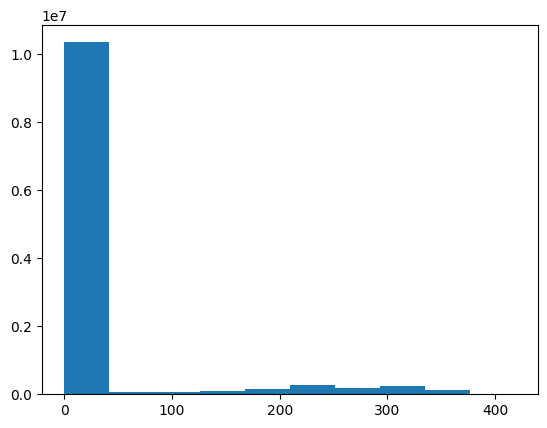

In [20]:
plt.hist(image_2.ravel(),bins=10)

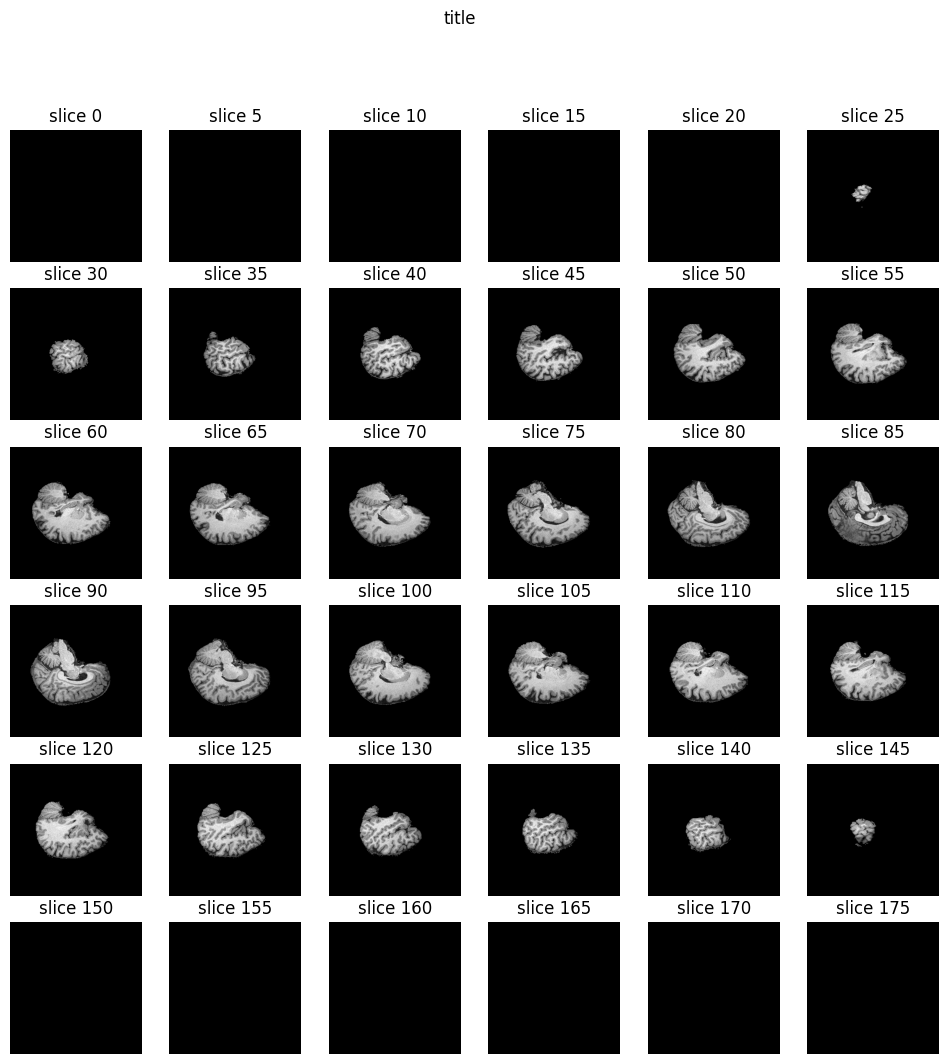

In [12]:
utils.stack_plot(image_1)

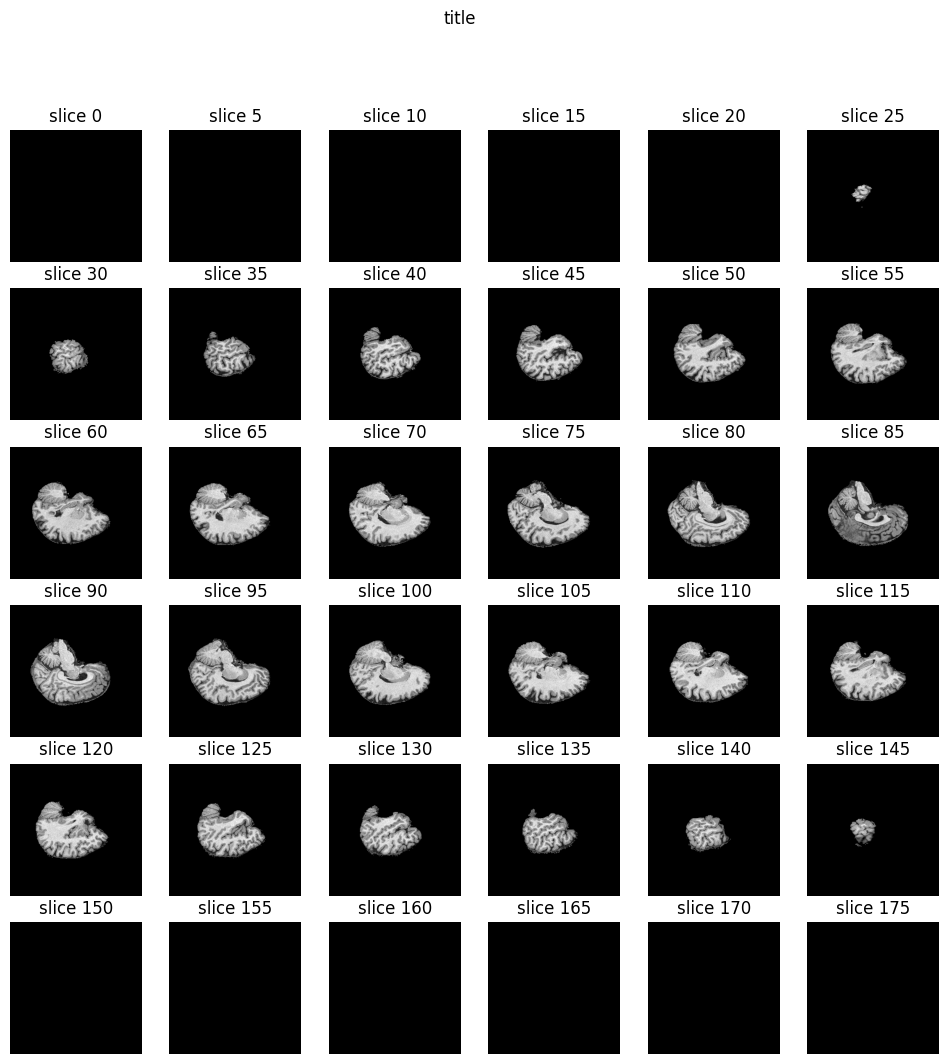

In [11]:
utils.stack_plot(image_2)

In [ ]:
def N4():
    print("N4 bias correction runs.")
    inputImage = sitk.ReadImage("06-t1c.nii.gz")
    # maskImage = sitk.ReadImage("06-t1c_mask.nii.gz")
    maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
    sitk.WriteImage(maskImage, "06-t1c_mask3.nii.gz")

    inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)

    corrector = sitk.N4BiasFieldCorrectionImageFilter();

    output = corrector.Execute(inputImage,maskImage)

In [6]:
sitk_t1.GetSpacing()

(0.9999975562095642, 0.9999999403953552, 1.0)

In [7]:
sitk_t1.GetSize()

(176, 256, 256)

In [ ]:
sitk_t2 = resample(sitk_t1,(1,1,1),(256,256,256))

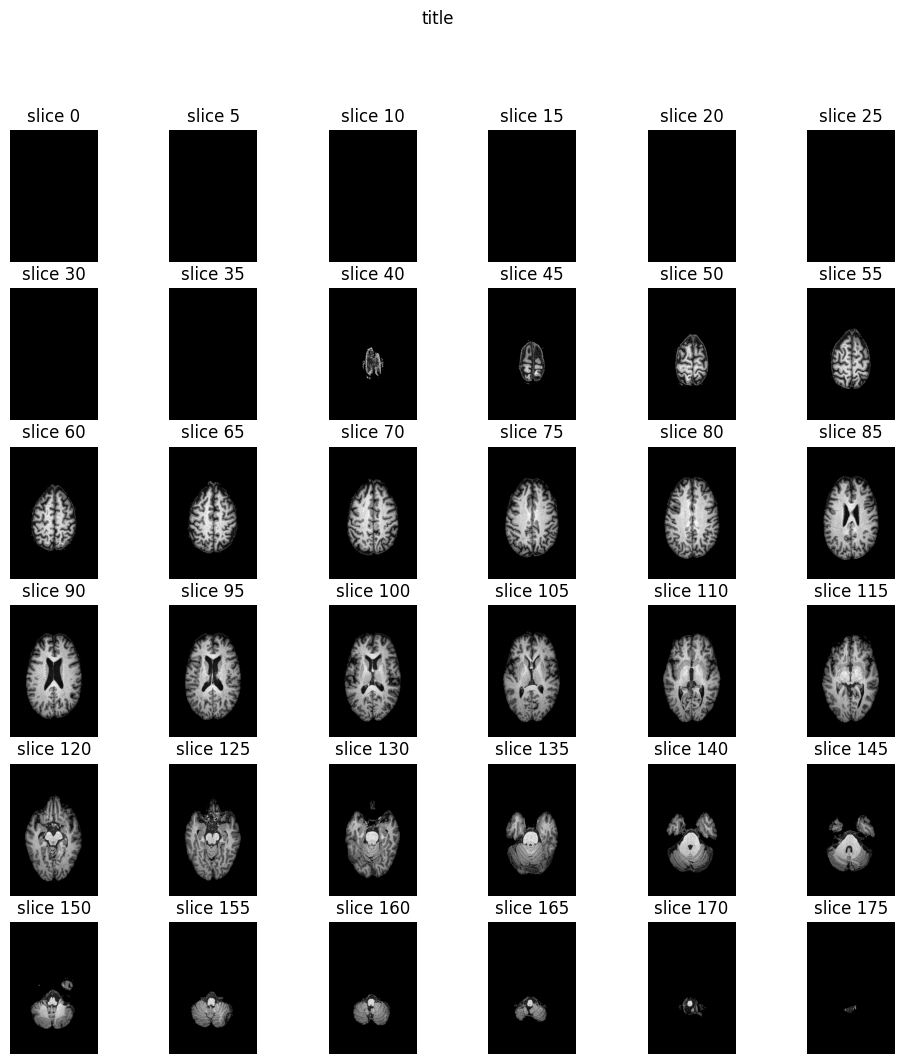

In [9]:
image = img_dataset[0]
image = minmax(image)
utils.stack_plot(image)

(161, 106, 138)
(128, 128, 128)
1.0
0.0


IndexError: index 130 is out of bounds for axis 2 with size 128

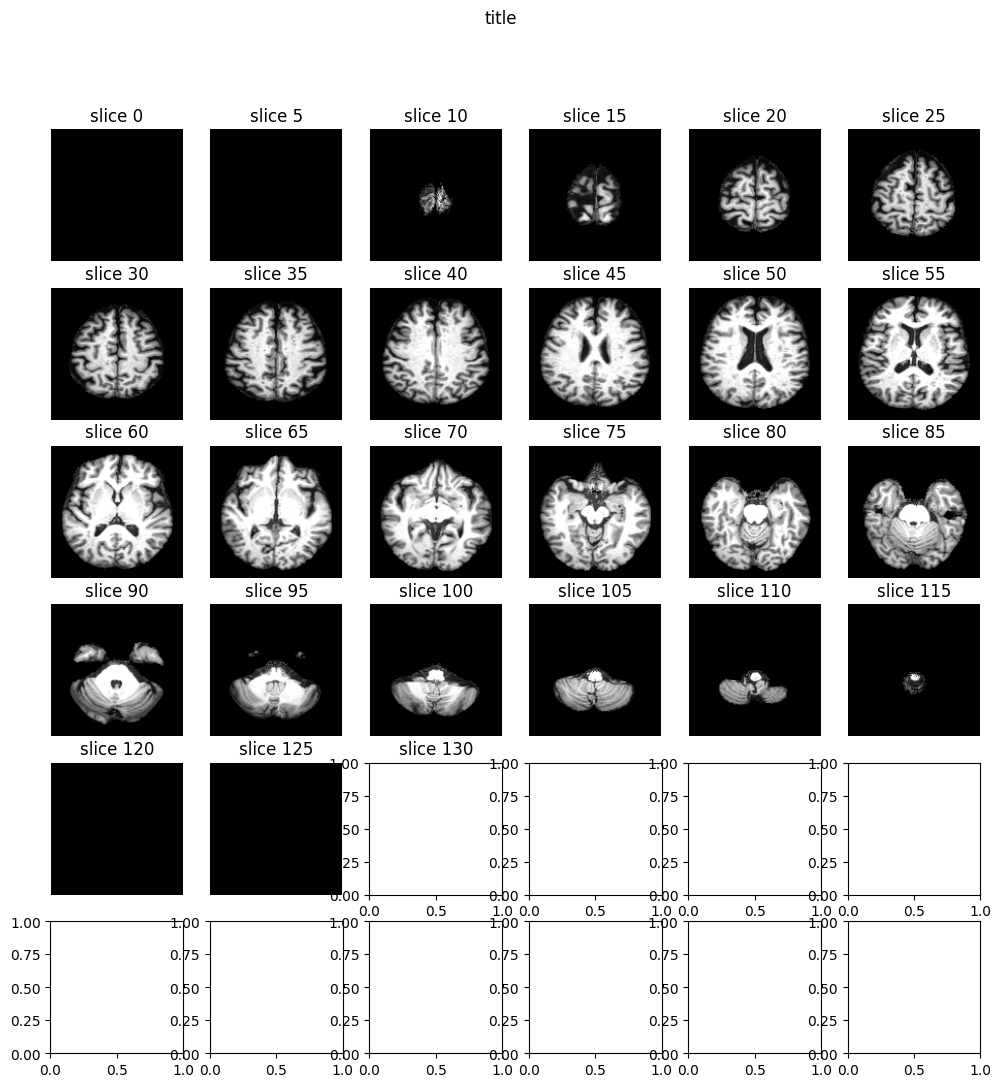

In [16]:
image = img_dataset[9]
image = window_image(image,600,1200)
image = crop_images(image)
print(image.shape)
image = add_pad(image)
image = resize(image)
image = minmax(image)
print(image.shape)
print(image.max())
print(image.min())
utils.stack_plot(image)

55 29
226 139
(256, 170)
(171, 110)


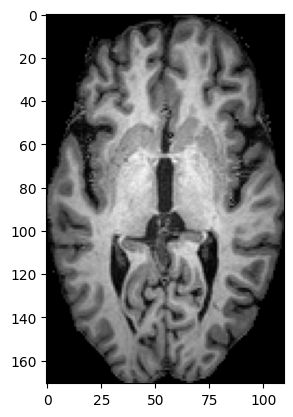

In [8]:
#image crop
sample_image = img_dataset[0][:,:,110]
sample_image_pre = crop_image(sample_image)
print(sample_image.shape)
print(sample_image_pre.shape)
utils.image_plot(sample_image_pre)